#Machine Prep

In [ ]:
%pip install pandas
!apt install graphviz libgraphviz-dev
%pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 35 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgail18 

###Module Import and Global Variable Construction

In [ ]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

#Pedigree Graph Construction

In [ ]:
def construct_pedigree_graph(df):
    G = nx.DiGraph()

    for _, row in df.iterrows():
        # Make sure IndividualID is treated as a string or int consistently if needed
        G.add_node(row['IndividualID'],
                  family=row['FamilyID'],
                  sex=row['Sex'],
                  phenotype=row['Phenotype'])

    for _, row in df.iterrows():
        # Ensure PaternalID and MaternalID are compared to string '0' if they are strings
        paternal_id = row['PaternalID']
        maternal_id = row['MaternalID']
        individual_id = row['IndividualID']

        if paternal_id != 0:
            G.add_edge(paternal_id, individual_id)
        if maternal_id != 0:
            G.add_edge(maternal_id, individual_id)

    return G

#Pedigree Visualization

In [ ]:
def plot_pedigree_tree(G, title="Pedigree (Tree Layout)"):
    try:
        from networkx.drawing.nx_agraph import graphviz_layout
        pos = graphviz_layout(G, prog='dot')  # 'dot' gives top-down DAG style
    except ImportError:
        print("PyGraphviz not installed. Falling back to spring layout.")
        pos = nx.spring_layout(G, seed=42)

    node_colors = ['red' if G.nodes[n]['phenotype'] == 2 else 'lightblue' for n in G.nodes]

    nx.draw(G, pos, with_labels=True, node_color=node_colors, arrows=True)
    plt.title(title)
    plt.show()

#Pedigree Generation

In [ ]:
def pedigree_generator(max_children, FamilyID, mode, generation_count, AffectedSpouse= False, BackpropLikelihood= False, alt_freq= 0):
        #-------------------------------------------
        # Helper Functions for Pedigree Propigation
        #-------------------------------------------

        '''
        Basic helper function to add new entry to pedigree dataframe
        '''
        def entry_generator(IndividualID, PaternalID, MaternalID, Sex, Phenotype, Genotype):
            nonlocal family_df
            family_df.loc[IndividualID] = [FamilyID, PaternalID, MaternalID, Sex, Phenotype, Genotype]

        '''
        Helper function to translate between genotype and phenotype
        Dependant on the mode of inheritance
        Input: genotype(int(0,1,2))
        Output: phenotype(int(1,2))
        '''
        def genotype_interpreter(genotype):
            if mode == 'AR':
                phenotype = 2 if genotype == 2 else 1
            if mode == 'AD':
                phenotype = 2 if genotype == 2 or genotype == 1 else 1
            return phenotype

        def calc_inheritance_weights(p,q):

            tt = q**4
            to = 2*p*(q**3)
            tz = (p**2)*(q**2)
            oo = 4*(p**2)*(q**2)
            oz = 2*(p**3)*(q)
            zz = p**4

            homoRef = p**2
            hetero = 2*p*q
            homoAlt = q**2

            inheritance_patterns = {
                'forward_genotypes': {
                #(paternal genotype, maternal genotype) -> [possible child genotypes]
                    (2,2): [2],
                    (2,1): [2,1],
                    (1,2): [2,1],
                    (2,0): [1],
                    (0,2): [1],
                    (1,1): [2,1,0],
                    (0,1): [1,0],
                    (1,0): [1,0],
                    (0,0): [0]
                },
                'forward_weights': {
                    (2,2): [1],
                    (2,1): [1,1],
                    (1,2): [1,1],
                    (2,0): [1],
                    (0,2): [1],
                    (1,1): [1,2,1],
                    (0,1): [1,1],
                    (1,0): [1,1],
                    (0,0): [1]
                },
                #child genotype -> [possible (paternal,maternal) genotypes]
                'reverse_genotypes': {
                    2: [(2,2),(2,1),(1,2),(1,1)],
                    1: [(2,1),(1,2),(2,0),(0,2),(1,1),(1,0),(0,1)],
                    0: [(1,0),(0,1),(0,0)]
                },
                'reverse_weights': {
                    2: [homoAlt**2, homoAlt*hetero, hetero*homoAlt, hetero**2],
                    1: [homoAlt*hetero, hetero*homoAlt, homoAlt*homoRef, homoRef*homoAlt, hetero**2, hetero*homoRef, homoRef*hetero],
                    0: [hetero*homoRef, homoRef*hetero, homoRef**2]
                }
            }

            return inheritance_patterns

        '''
        Wrapper function that generates the primary founder of the pedigree
        By default, this individual is affected
        If AD, 20% chance homozygous, 80% chance heterozygous.
        If AR, 100% chance homozygous.
        Input:
        Output:
        '''
        def primary_founder_generator():
            nonlocal family_df

            if mode == 'AD':
                Genotype = random.choices(population= [1,2],
                                          weights= (0.8, 0.2))[0]
            elif mode == 'AR':
                Genotype= 2

            entry_generator(IndividualID= 1,
                            PaternalID= 0,
                            MaternalID= 0,
                            Sex= random.randint(1,2),
                            Phenotype= 2,
                            Genotype= Genotype)
        '''
        Wrapper function that generates spouses unrelated to primary founder
        Spouse sex dependent on the relative of primary founder.
        Genotype and phenotype dependent on the mode of inheritance and affected spouse paramter.
        Input: relativeID(int)
        Ouput: n/a
        '''
        def spouse_generator(RelativeAnchorID):
            nonlocal family_df, alt_freq, ref_freq

            pp = ref_freq**2
            pq2 = 2*ref_freq*alt_freq
            qq = alt_freq**2

            Sex= 1 if family_df.loc[RelativeAnchorID]['Sex'] == 2 else 2

            if AffectedSpouse:
                Genotype= random.choices(population= [0,1,2],
                                          weights= (pp, pq2, qq),
                                          k=1)[0]

            else:
                Genotype = 0

            entry_generator(IndividualID= len(family_df)+1,
                            PaternalID= 0,
                            MaternalID= 0,
                            Sex= Sex,
                            Phenotype= genotype_interpreter(Genotype),
                            Genotype= Genotype)
        '''
        Wrapper function that generates an entry for the child of two given individuals.
        Child's genotype is chosen from list of allowed gentypes given parents genotypes with equal likelihood.
        Input: PaternalID(int), MaternalID(int)
        Output: n/a
        '''
        def child_generator(PaternalID, MaternalID):
            nonlocal family_df, inheritance_patterns

            parentalGenotype = (int(family_df.loc[PaternalID]['Genotype']), int(family_df.loc[MaternalID]['Genotype']))

            Genotype = random.choices(population= inheritance_patterns['forward_genotypes'][parentalGenotype],
                                      weights= inheritance_patterns['forward_weights'][parentalGenotype],
                                      k=1)[0]

            entry_generator(IndividualID= len(family_df)+1,
                            PaternalID= PaternalID,
                            MaternalID= MaternalID,
                            Sex= random.randint(1,2),
                            Phenotype= genotype_interpreter(Genotype),
                            Genotype= Genotype)
        #---------------------------------------
        # Primary Pedigree Contruction Functions
        #---------------------------------------
        '''
        Function that recursively constructs pedigree in backward direction.
        Infers ancestors of individuals unrelated to primary founder as they are added.
        Input: current_generation(int), RealativeAnchorID(int)
        Output: n/a
        '''
        def recursive_history_backprop(current_generation, RelativeAnchorID):
            nonlocal family_df, generation_count, inheritance_patterns, BackpropLikelihood

            BackpropRNG = random.randint(1,100)/100

            if current_generation > 0 and BackpropRNG <= BackpropLikelihood:

                GenotypeTup = random.choices(population= inheritance_patterns['reverse_genotypes'][family_df.loc[RelativeAnchorID]['Genotype']],
                                                    weights= inheritance_patterns['reverse_weights'][family_df.loc[RelativeAnchorID]['Genotype']],
                                                    k=1)[0]

                ID_list = ['PaternalID', 'MaternalID']

                for i in range(2):
                    entry_generator(IndividualID= len(family_df)+1,
                                    PaternalID= 0,
                                    MaternalID= 0,
                                    Sex= 1 + i,
                                    Phenotype= genotype_interpreter(GenotypeTup[i]),
                                    Genotype= GenotypeTup[i])
                    family_df.at[RelativeAnchorID, ID_list[i]] = len(family_df)
                    recursive_history_backprop(current_generation-1, len(family_df))

        '''
        Function that recursively constructs pedigree in forward direction.
        Input: current_generation(int), RelativeAnchorID(int)
        Output: n/a
        '''
        def recursive_pedigree_construction(current_generation, RelativeAnchorID):
            nonlocal family_df, max_children, generation_count

            if current_generation < generation_count-1:

                spouse_generator(RelativeAnchorID= RelativeAnchorID)

                #Determining Parental Sex for next generation
                if family_df.loc[RelativeAnchorID]['Sex'] == 1:
                    PaternalID = RelativeAnchorID
                    MaternalID = len(family_df)
                else:
                    PaternalID = len(family_df)
                    MaternalID = RelativeAnchorID

                if BackpropLikelihood:
                    recursive_history_backprop(current_generation, len(family_df))

                for child in range(random.randint(1, max_children)):
                    child_generator(PaternalID= PaternalID, MaternalID= MaternalID)
                    recursive_pedigree_construction(current_generation+1, len(family_df))


        #-------------------------------------
        # 1. Construct the empty data frame
        #-------------------------------------
        pedigree_construction_columns = ['FamilyID', 'IndividualID', 'PaternalID', 'MaternalID', 'Sex', 'Phenotype', 'Genotype']
        family_df = pd.DataFrame(columns= pedigree_construction_columns)
        print(family_df)
        family_df.set_index('IndividualID', inplace=True)

        #-------------------------------------
        # 2. Generating Primary Founder
        #-------------------------------------
        primary_founder_generator()
        print(family_df)

        #--------------------------------------------
        # 3. Construct Inheritence Pattern Dictionary
        #--------------------------------------------
        ref_freq = 1 - alt_freq
        inheritance_patterns = calc_inheritance_weights(ref_freq, alt_freq)

        #----------------------------------------
        # 4. Generating Pedigree
        #----------------------------------------
        recursive_pedigree_construction(current_generation= 0, RelativeAnchorID= 1)

        #-------------------------------
        # 5. Resetign Standard Indexing
        #-------------------------------
        family_df.reset_index(inplace= True)

        return family_df

#Trial Runs

Empty DataFrame
Columns: [FamilyID, IndividualID, PaternalID, MaternalID, Sex, Phenotype, Genotype]
Index: []
             FamilyID  PaternalID  MaternalID  Sex  Phenotype  Genotype
IndividualID                                                           
1                Fam1           0           0    2          2         1
    IndividualID FamilyID  PaternalID  MaternalID  Sex  Phenotype  Genotype
0              1     Fam1           0           0    2          2         1
1              2     Fam1           0           0    1          2         1
2              3     Fam1           2           1    1          2         1
3              4     Fam1           5           6    2          2         1
4              5     Fam1           0           0    1          1         0
5              6     Fam1           0           0    2          2         1
6              7     Fam1           3           4    1          2         2
7              8     Fam1           3           4    1          2 

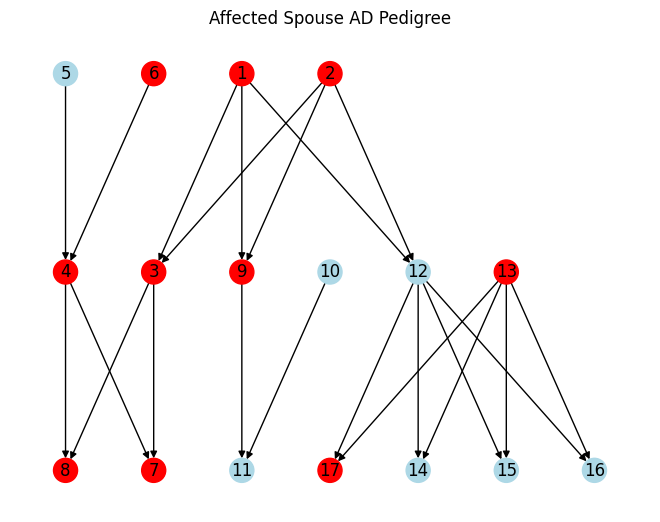

In [ ]:
#Testing new pedigree generator
test_df = pedigree_generator(max_children= 4,
                             FamilyID= 'Fam1',
                             mode= 'AD',
                             generation_count= 2,
                             AffectedSpouse= True,
                             alt_freq= 0.1,
                             BackpropLikelihood= 0.5)
print(test_df)
test_dg = construct_pedigree_graph(test_df)
plot_pedigree_tree(test_dg, "Affected Spouse AD Pedigree")

In [ ]:
print(test_df.loc[1]['Sex'])

2
